In [8]:
import numpy as np
import matplotlib.pyplot as plt
import qpsolvers

In [9]:
dt = 0.001
leap_mpc = 32
dt_mpc = leap_mpc * dt 

DimS = 4
DimU = 1

M = 4.0 # cart mass
m = 0.2 # bar mass
l = 0.5 # half bar length
b1 = 0.01 # cart viscous friction ratio
b2 = 0.01 # bar angular viscous friction ratio
gra = 9.81 # gravity
I = 1/3.0 * m * 4 * l**2 # inertia of bar

N = (M + m) * (I + m * l**2) - m**2 * l**2

# q = [x xdot th thdot]

# qdot = Aq + Bu
A = np.array(
    [[0, 1, 0, 0],
     [0, -b1*(I+m*l*l)/N, -m*m*gra*l*l/N, b2*m*l/N],
     [0, 0, 0, 1],
     [0, b1*m*l/N, (M+m)*m*gra*l/N, -b2*(M+m)/N]
    ])

B = np.array(
    [0, (I+m*l*l)/N, 0, -m*l/N]
)

Ak = np.eye(4) + dt * A
Bk = dt * B

# qk+1 = Ak_mpc * qk + Bk_mpc * uk
Ak_mpc = np.eye(4) + dt_mpc * A
Bk_mpc = dt_mpc * B

# lb < uk < ub
LBk = np.array([-50])
UBk = np.array([50])

x0 = np.array([1, 1, 0.2, 0.7])
u = 0


In [10]:
horizon_length = 50
Q = np.diag([10000, 1, 10000, 1])
R = np.diag([10])

Abar = np.zeros((DimS*horizon_length, DimS))
Bbar = np.zeros((DimS*horizon_length, DimU * horizon_length))
Abar[0:DimS,0:DimS] = Ak_mpc

for i in range(1, horizon_length):
    Abar[0+i*DimS:DimS+i*DimS,0:DimS] = Ak_mpc @ Abar[0+(i-1)*DimS:DimS+(i-1)*DimS, 0:DimS]

for col in range(0, horizon_length):
    for row in range(0, horizon_length):
        if row < col:
            continue
        elif row == col:
            Bbar[0+row*DimS:DimS+row*DimS, 0+col*DimU:DimU+col*DimU] = np.reshape(Bk_mpc, (DimS, DimU))
        else:
            Bbar[0+row*DimS:DimS+row*DimS, 0+col*DimU:DimU+col*DimU] = \
                Ak_mpc @ Bbar[0+(row-1)*DimS:DimS+(row-1)*DimS, 0+col*DimU:DimU+col*DimU]
        
Qbar = np.zeros((DimS*horizon_length, DimS*horizon_length))
Rbar = np.zeros((DimU*horizon_length, DimU*horizon_length))

for cr in range(0, horizon_length):
    Qbar[0+cr*DimS:DimS+cr*DimS, 0+cr*DimS:DimS+cr*DimS] = Q
    Rbar[0+cr*DimU:DimU+cr*DimU, 0+cr*DimU:DimU+cr*DimU] = R

H = Rbar + Bbar.T @ Qbar @ Bbar
GG = Abar.T @ Qbar @ Bbar

LBBar = np.zeros(DimU*horizon_length)
UBBar = np.zeros(DimU*horizon_length)

for row in range(0, horizon_length):
    LBBar[0+row*DimU:DimU+row*DimU] = LBk
    UBBar[0+row*DimU:DimU+row*DimU] = UBk

In [11]:
#try solve QP problem

sim_total_count = 6000
t = np.zeros(sim_total_count)
x = np.zeros((DimS, sim_total_count))
ul = np.zeros((DimU, sim_total_count))

x[:, 0] = x0
ul[:, 0] = np.zeros((DimU, 1))

u_mpc = np.zeros(horizon_length)

for i in range(1, sim_total_count):
    # print(i)
    t[i] = i * dt
    # solve MPC every mpc_leap cycle
    if i % leap_mpc == 0:
        Gk = np.reshape(x[:, i-1], (DimS, 1)).T @ GG
        #print(Gk)
        u_mpc = qpsolvers.solve_qp(P=H, q=Gk.flatten(), lb=LBBar.flatten(), ub=UBBar.flatten(), solver="quadprog")

    # do simulation
    x[:, i] = Ak @ x[:, i-1] + np.reshape(u_mpc[0] * Bk, (DimS))
    ul[:, i] = np.reshape(u_mpc[0], (DimU, 1))



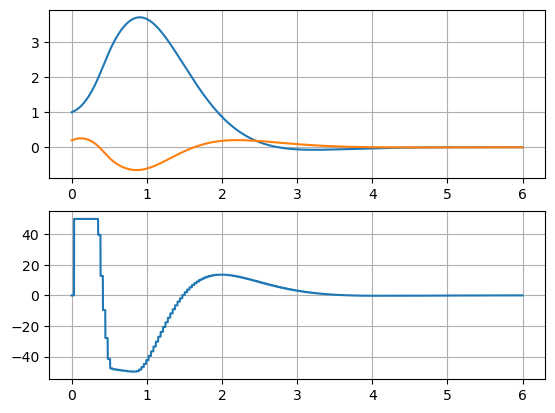

In [12]:
plt.subplot(2,1,1)
plt.plot(t, x[0, :], t, x[2,:])
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(t, ul.flatten())
plt.grid(True)